# Model at department level

In [3]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
sys.path.append("C:/git/case7-lockdown-exit-strategy/")

from covid.models.examples.covid import COVID19
from covid.dataset import fetch_daily_case_france

# Visualization at department level
- https://plotly.com/python/choropleth-maps/
- https://france-geojson.gregoiredavid.fr/

## Example to visualize in the notebook
Also valid in streamlit

In [5]:
import json

json_file = "../data/raw/departements.geojson"
json_data = json.loads(open(json_file,"r").read())
json.dumps(json_data)[:300]

'{"type": "FeatureCollection", "features": [{"type": "Feature", "geometry": {"type": "Polygon", "coordinates": [[[3.172704445659, 50.011996744997], [3.1821975358417, 50.012335988197], [3.2174797791605, 50.023182479597], [3.230541907493, 50.031311385584], [3.2579143291896, 50.024436966985], [3.2581174'

In [6]:
def transform(x):
    try:
        code = int(x["code"])
        if code > 30:
            return [255,0,0]
        elif code > 20:
            return [0,255,0]
        else:
            return [0,255,255]
    except:
        return [0,255,255]

In [7]:
def add_property(geojson,name,fn):
    for feature in geojson["features"]:
        feature["properties"][name] = fn(feature["properties"])

In [8]:
add_property(json_data,"color",transform)

In [9]:
from covid.visualization.map import show_geojson_pydeck_choropleth

In [10]:
show_geojson_pydeck_choropleth(json_data)

'c:\\git\\case7-lockdown-exit-strategy\\notebooks\\pydeckv5hphwch.html'

# Get data at department level

In [11]:
from covid.dataset import fetch_daily_case
from covid.dataset import fetch_daily_case_departement,fetch_list_available_departements
from covid.dataset import fetch_population,fetch_bed
from covid.utils import clean_series

In [12]:
dep = "01"
cases = fetch_daily_case_departement(dep,smooth = True)
cases.head()

,deces,gueris,hospitalises,reanimation,D,R,H,ICU
2020-03-18,0.0,1.0,2.0,0.0,0.0,1.000000,1.369595,0.00000
2020-03-19,0.0,1.0,2.0,0.0,0.0,1.000000,2.080638,0.00000
2020-03-20,0.0,1.0,2.0,0.0,0.0,1.254114,3.159095,1.00000
2020-03-21,0.0,1.0,4.0,0.0,0.0,1.912719,5.029717,1.00000
2020-03-22,0.0,2.0,8.0,1.0,0.0,3.159159,8.212620,1.06549


In [13]:
pop = fetch_population(return_data = True).set_index("Départements_ID")
pop.head()

N_dep = pop.loc[dep,"Ensemble_Total"]
print(N_dep)

656955


In [14]:
beds = fetch_bed(return_data = True)
beds.head()

,Code,Libellé,rea_adultes_public,rea_adultes_bnl,rea_adultes_bl,rea_enfants_public,rea_enfants_bnl,rea_enfants_bl,intensif_usic_public,intensif_usic_bnl,...,intensif_unv_bl,intensif_autres_public,intensif_autres_bnl,intensif_autres_bl,continu_adultes_public,continu_adultes_bnl,continu_adultes_bl,continu_enfants_public,continu_enfants_bnl,continue_enfants_bl
0,FR,France entière,4247,542,261,361,0,21,1823,721,...,32,1840,154,230,3550,2983,740,745,2,42
1,MET,France métropolitaine,4123,542,261,343,0,21,1763,713,...,32,1794,148,230,3498,2937,740,722,2,42
2,01,Ain,12,10,0,0,0,0,0,6,...,0,0,0,0,13,5,0,4,0,0
3,02,Aisne,34,0,0,0,0,0,34,0,...,0,5,4,0,20,12,0,0,0,0
4,03,Allier,24,0,0,0,0,0,22,0,...,0,0,0,0,10,10,0,6,0,0


In [8]:
# Prepare model
# Calibrated on French Data without nursing homes with priors from litterature
params = {
    'beta_low': 0.24634216728429806,
    'beta_high': 1.8347320721720688,
    'offset': 0,
    'proba_hospital_to_icu': 0.15624158268969202,
    'proba_death_hospital': 0.1643094748407844,
    'recovery_duration_hospital': 7.2631180160024735,
    'recovery_duration_icu': 2.0250261278505524,
    'death_duration_icu': 59.30284155266353,
    'death_duration_hospital':12.746333088830141
}

N = N_dep
class COVID19Model(COVID19):
    def __init__(self,params = None):
        if params is not None:
            self.reset(params)
        
    def reset(self,params):        
        beta = [params["beta_high"],[params["beta_low"]],[-1 - params["offset"]]]
        super().__init__(N = N,
            beta = beta,
            offset = params["offset"],
            proba_hospital_to_icu = params["proba_hospital_to_icu"],
            proba_death_hospital = params["proba_death_hospital"],
            recovery_duration_icu = params["recovery_duration_icu"],
            recovery_duration_hospital = params["recovery_duration_hospital"],
            death_duration_hospital = params["death_duration_hospital"],
            death_duration_icu = params["death_duration_icu"],
        )
        
model = COVID19Model(params)
init_state = {"S":N_dep-1,"E":1}

TypeError: __init__() got an unexpected keyword argument 'proba_hospital_to_icu'

In [42]:
space = {
    "beta_low":(0.01,0.4),
    "beta_high":(0.6,2),
    "offset":(-20,20),
    "proba_hospital_to_icu":(0.13,0.22),
    "proba_death_hospital":(0.01,0.2),
    "recovery_duration_hospital":(5,20),
    "recovery_duration_icu":(5,20),
    "death_duration_icu":(10,100),
    "death_duration_hospital":(10,100),
}

In [43]:
model.fit(cases[["D","H","ICU"]],space,init_state,n = 100,early_stopping = 20)

... Early stopping - best value has not changed since 20 trials at 0.7863357384518309
... Found best solution {'beta_low': 0.09256146102724686, 'beta_high': 1.6463121581066682, 'offset': -19.927191780676896, 'proba_hospital_to_icu': 0.15795452625159306, 'proba_death_hospital': 0.11949968481572822, 'recovery_duration_hospital': 14.262389593941275, 'recovery_duration_icu': 19.122717499995332, 'death_duration_icu': 10.109547076872161, 'death_duration_hospital': 10.286417074229657} for value 0.7863357384518309


In [12]:
params = {'beta_low': 0.09256146102724686, 'beta_high': 1.6463121581066682, 'offset': -19.927191780676896, 'proba_hospital_to_icu': 0.15795452625159306, 'proba_death_hospital': 0.11949968481572822, 'recovery_duration_hospital': 14.262389593941275, 'recovery_duration_icu': 19.122717499995332, 'death_duration_icu': 10.109547076872161, 'death_duration_hospital': 10.286417074229657}

In [ ]:
model = COVID19(params)

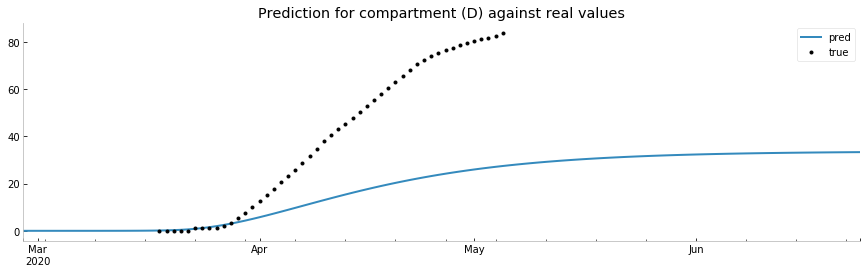

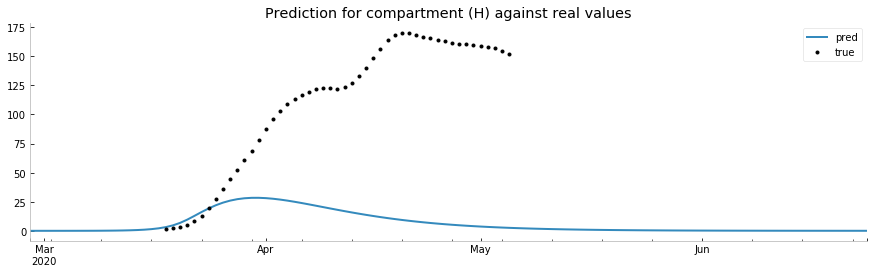

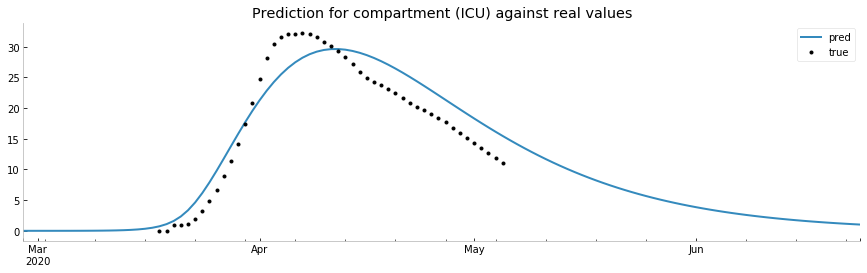

In [44]:
model.show_prediction(cases[["D","H","ICU"]],init_state,forecast_days = 50)

# Brute force loop over each "departement"

In [9]:
from covid.dataset import fetch_daily_case
from covid.dataset import fetch_daily_case_departement,fetch_list_available_departements
from covid.dataset import fetch_population,fetch_bed
from covid.utils import clean_series

In [11]:
deps = sorted(fetch_list_available_departements())
print(deps)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2A', '2B', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '971', '972', '973', '974', '976']


In [12]:
space = {
    "beta_low":(0.01,0.4),
    "beta_high":(0.6,2),
    "offset":(-30,30),
    "proba_icu":(0.13,0.22),
    "proba_death_hospital":(0.01,0.2),
    "recovery_duration_hospital":(5,20),
    "recovery_duration_icu":(5,20),
    "death_duration_icu":(10,100),
    "death_duration_hospital":(10,100),
}


class COVID19Departement(COVID19):
    def __init__(self,N,start_date,params = None):
        self.N = N
        self.start_date = start_date
        self.lockdown_start = (pd.to_datetime("2020-03-17") - pd.to_datetime(self.start_date)).days
        print(f"Initialized with N={self.N} and lockdown {self.lockdown_start} after {self.start_date}")
        if params is not None:
            self.reset(params)
        
    def reset(self,params):        
        beta = [params["beta_high"],[params["beta_low"]],[self.lockdown_start - params["offset"]]]
        super().__init__(N = self.N,
            beta = beta,
            offset = params["offset"],
            proba_icu = params["proba_icu"],
            proba_death_hospital = params["proba_death_hospital"],
            recovery_duration_icu = params["recovery_duration_icu"],
            recovery_duration_hospital = params["recovery_duration_hospital"],
            death_duration_hospital = params["death_duration_hospital"],
            death_duration_icu = params["death_duration_icu"],
        )
        



def optimize_dep(dep,n = 1000,early_stopping = 200):
    
    # Get values
    cases = fetch_daily_case_departement(dep,smooth = True)
    pop = fetch_population(return_data = True).set_index("Départements_ID")
    N_dep = pop.loc[dep,"Ensemble_Total"]
    init_state = {"S":N_dep-1,"E":1}

    # Initialize model
    model_dep = COVID19Departement(N_dep,cases.index[0])
    
    # Optimize and save params
    model_dep.fit(cases[["D","H","ICU"]],space,init_state,n = n,early_stopping = early_stopping,info = {"Departement":dep},save = True,filename = f"params/calibration_DEP-{dep}.yaml")
    
    # Visualize prediction
    model_dep.show_prediction(cases[["D","H","ICU"]],init_state,forecast_days = 50,save = True,filename = f"img/prediction_DEP-{dep}.png")

DEP=01====================================================================================================
Initialized with N=656955 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.24546383770144903
... Found best solution {'beta_low': 0.20336568540836075, 'beta_high': 1.5988779474489374, 'offset': -22.56865624173794, 'proba_icu': 0.16282882817266528, 'proba_death_hospital': 0.15793750166979423, 'recovery_duration_hospital': 17.32602325514526, 'recovery_duration_icu': 14.146525195672934, 'death_duration_icu': 13.122254596490396, 'death_duration_hospital': 13.019389045568944} for value 0.24546383770144903
... Parameters saved in yaml file params/calibration_DEP-01.yaml
                    D           H        ICU
2020-03-18   0.000000    1.369595   0.000000
2020-03-19   0.000000    2.080638   0.000000
2020-03-20   0.000000    3.159095   1.000000
2020-03-21   0.000000    5.029717   1.000000
2020-03-22   0.000000    8.212620   1.065490
2020-03-23   1.000000   13.128405   1.979678
2020-03-24   1.000000   19.636694   3.214170
2020-03-25   1.000000   27.318224   4.805391
2020-03-26   1.127695   35.63

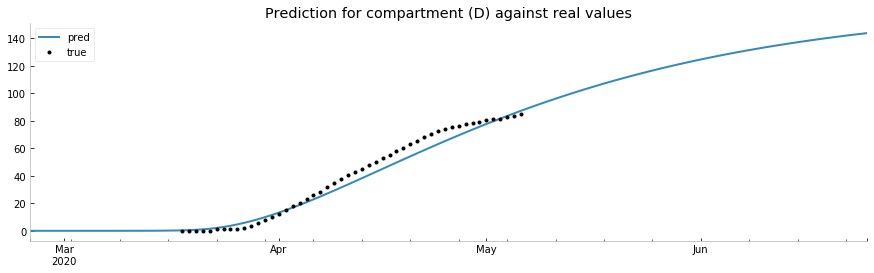

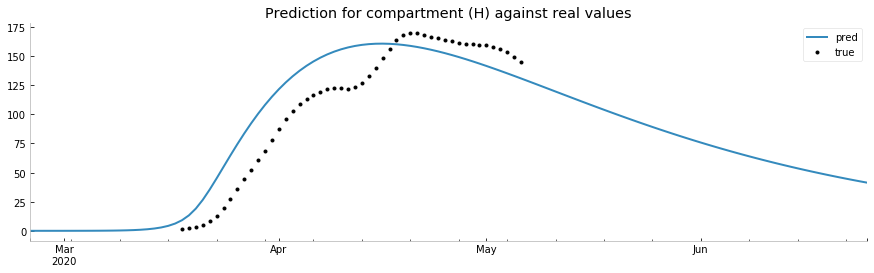

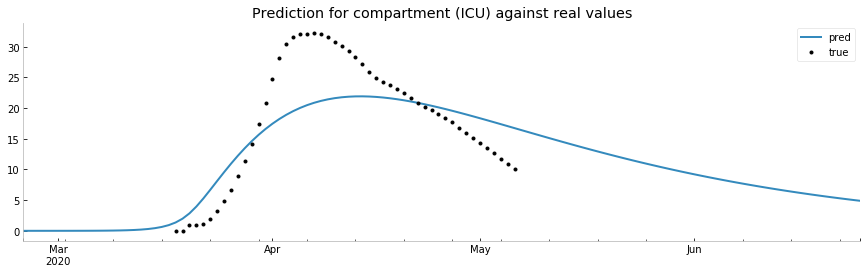

DEP=02====================================================================================================
Initialized with N=526050 and lockdown -1 after 2020-03-18 00:00:00


... Found best solution {'beta_low': 0.25693862649468835, 'beta_high': 1.416449306239926, 'offset': -27.223685345076355, 'proba_icu': 0.20954539616992568, 'proba_death_hospital': 0.17148526277652584, 'recovery_duration_hospital': 10.256001703914809, 'recovery_duration_icu': 5.515333024719353, 'death_duration_icu': 29.88568944905697, 'death_duration_hospital': 10.031293294775859} for value 0.21579258169054874
... Parameters saved in yaml file params/calibration_DEP-02.yaml
                     D           H        ICU
2020-03-18   13.448134   39.024288  11.446457
2020-03-19   17.118233   45.302971  14.047930
2020-03-20   21.055608   52.981160  16.837062
2020-03-21   24.703172   62.390882  19.524084
2020-03-22   27.853045   73.729333  22.116905
2020-03-23   30.448824   86.825784  24.795585
2020-03-24   32.577519  100.126174  27.634798
2020-03-25   34.346711  111.950007  30.386704
2020-03-26   35.999790  121.441951  32.597902
2020-03-27   37.780020  128.445554  34.017763
2020-03-28   39.9

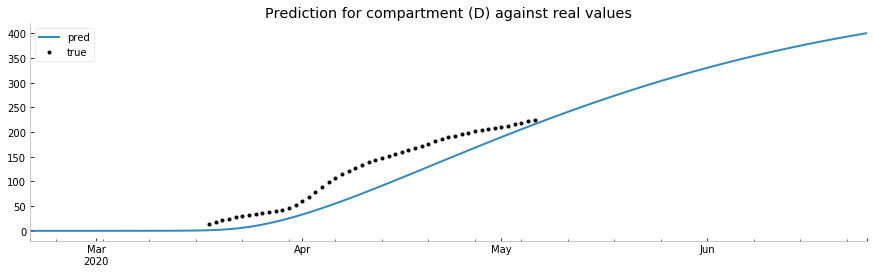

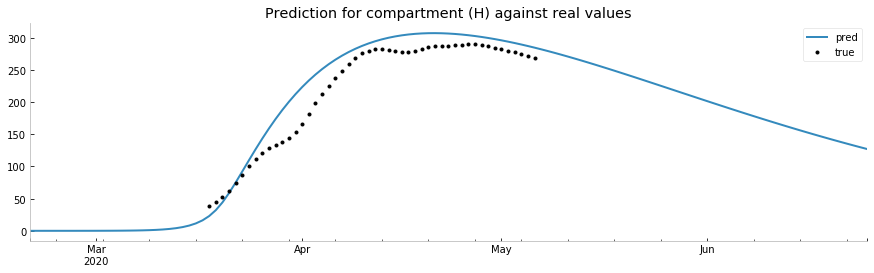

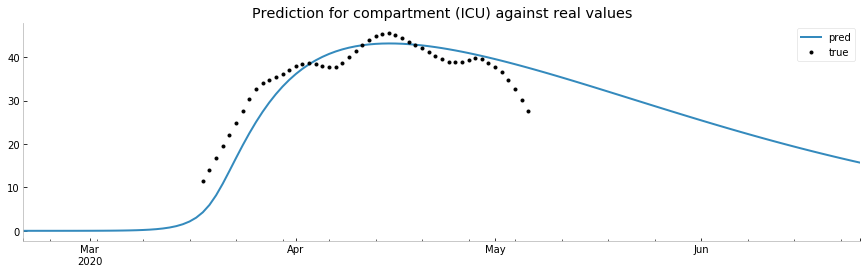

DEP=03====================================================================================================
Initialized with N=331315 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.2274014940167624
... Found best solution {'beta_low': 0.183340990953592, 'beta_high': 1.7521984129506825, 'offset': -18.817238681517647, 'proba_icu': 0.20541061199974014, 'proba_death_hospital': 0.18682455272767917, 'recovery_duration_hospital': 19.115695671064216, 'recovery_duration_icu': 19.973786851192365, 'death_duration_icu': 63.73034778490888, 'death_duration_hospital': 15.832594433090424} for value 0.2274014940167624
... Parameters saved in yaml file params/calibration_DEP-03.yaml
                    D          H        ICU
2020-03-18   0.000000   2.519070   0.000000
2020-03-19   0.000000   2.647682   0.000000
2020-03-20   1.000000   2.999565   0.000000
2020-03-21   1.000000   3.874724   0.000000
2020-03-22   1.000000   5.211646   0.000000
2020-03-23   1.000000   7.046231   1.000000
2020-03-24   1.000000   9.244916   1.000000
2020-03-25   1.444862  11.836912   1.000000
2020-03-26   2.095437  14.786064   1.0000

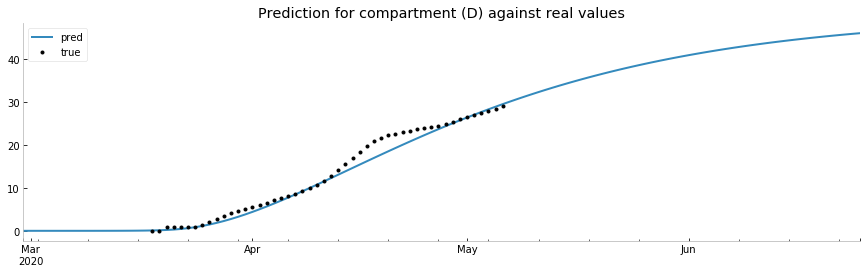

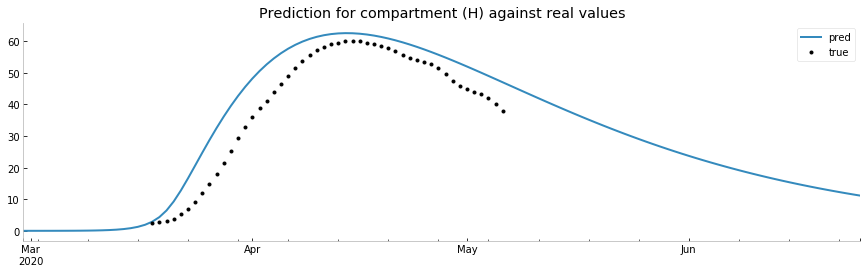

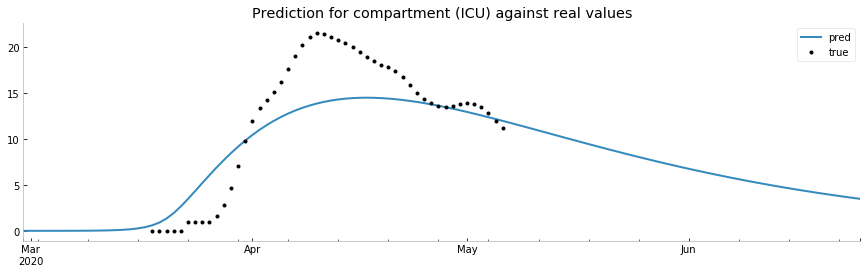

DEP=04====================================================================================================
Initialized with N=165197 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.20368102096941407
... Found best solution {'beta_low': 0.18592693153113798, 'beta_high': 1.6802518743704713, 'offset': -17.922443961849105, 'proba_icu': 0.21829818678125726, 'proba_death_hospital': 0.14282527519132013, 'recovery_duration_hospital': 19.029037558832016, 'recovery_duration_icu': 5.543471094033487, 'death_duration_icu': 32.45194689626583, 'death_duration_hospital': 21.795241763047194} for value 0.20368102096941407
... Parameters saved in yaml file params/calibration_DEP-04.yaml
                   D          H       ICU
2020-03-18  1.000000   2.819368  1.009295
2020-03-19  1.000000   3.008185  1.002964
2020-03-20  0.000000   3.237552  1.000000
2020-03-21  0.000000   3.545296  1.000000
2020-03-22  0.000000   3.935706  1.000000
2020-03-23  0.000000   4.497456  1.000000
2020-03-24  0.000000   5.376529  1.000000
2020-03-25  0.000000   6.702133  1.000000
2020-03-26  0.000000   8.318317  1.000000
2020-03-27  1.

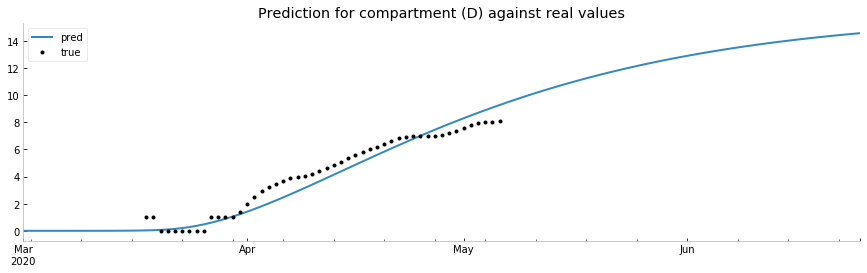

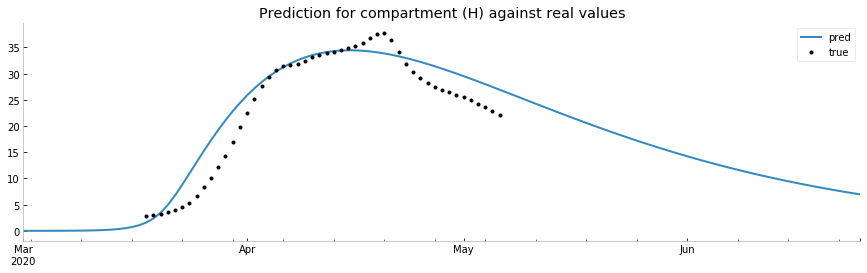

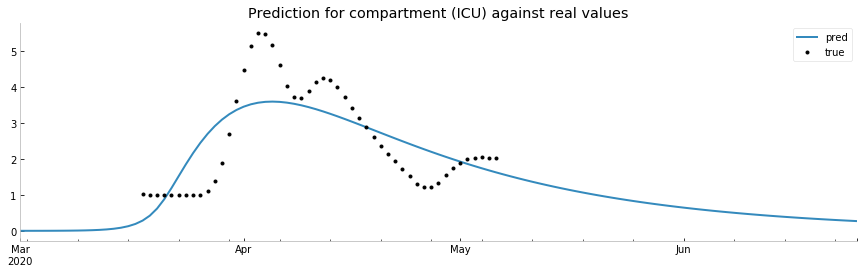

DEP=05====================================================================================================
Initialized with N=141756 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.1832353067094677
... Found best solution {'beta_low': 0.15186301722672765, 'beta_high': 1.3369730169557354, 'offset': -23.853317809544407, 'proba_icu': 0.21696256079719745, 'proba_death_hospital': 0.13972874157037, 'recovery_duration_hospital': 16.85512150326032, 'recovery_duration_icu': 17.28578427942768, 'death_duration_icu': 72.02274052503947, 'death_duration_hospital': 40.37198524617486} for value 0.1832353067094677
... Parameters saved in yaml file params/calibration_DEP-05.yaml
                   D          H        ICU
2020-03-18  0.000000   8.395215   1.000000
2020-03-19  0.000000   9.920056   1.000000
2020-03-20  0.000000  11.605403   1.055818
2020-03-21  1.000000  13.368879   1.300817
2020-03-22  1.000000  15.354426   1.731304
2020-03-23  1.000000  17.715387   2.427802
2020-03-24  1.000000  20.385095   3.312523
2020-03-25  1.000000  23.489683   4.286363
2020-03-26  1.000000  26.910813   5.283624
2020-03-27 

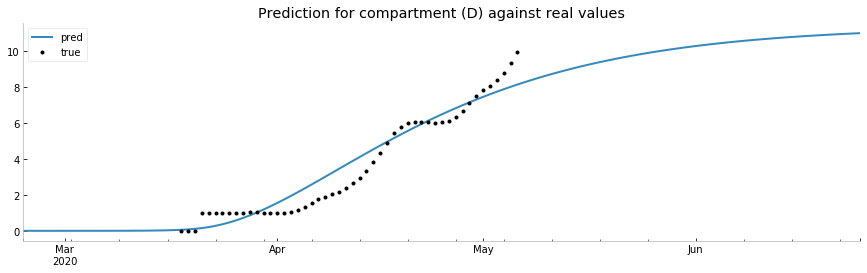

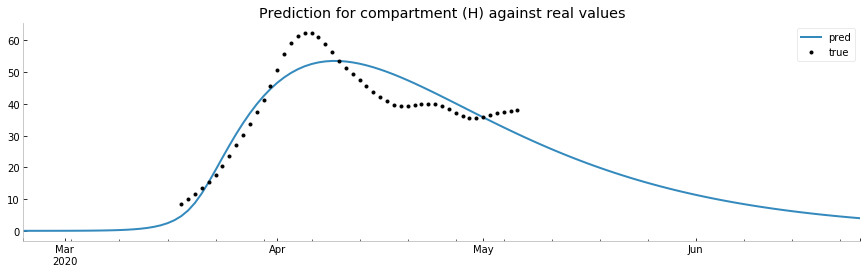

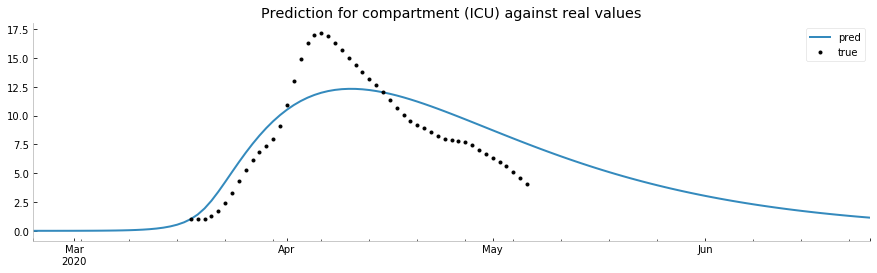

DEP=06====================================================================================================
Initialized with N=1079396 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.27337456587907133
... Found best solution {'beta_low': 0.17759883942276977, 'beta_high': 1.4340209873498062, 'offset': -27.77283601074301, 'proba_icu': 0.21429233095992617, 'proba_death_hospital': 0.1541068630658267, 'recovery_duration_hospital': 12.886477812620958, 'recovery_duration_icu': 9.801224136024386, 'death_duration_icu': 35.5965999853361, 'death_duration_hospital': 14.031274649691198} for value 0.27337456587907133
... Parameters saved in yaml file params/calibration_DEP-06.yaml
                     D           H        ICU
2020-03-18    1.887481   27.079266   1.945090
2020-03-19    2.712495   32.498393   3.437564
2020-03-20    3.802516   38.474461   5.284920
2020-03-21    5.078233   44.493492   7.253421
2020-03-22    6.366153   50.659689   9.303478
2020-03-23    7.556964   57.535075  11.474376
2020-03-24    8.665201   64.791808  13.622102
2020-03-25    9.854716   73.513246  15.875052
2020-03-26   11.254391 

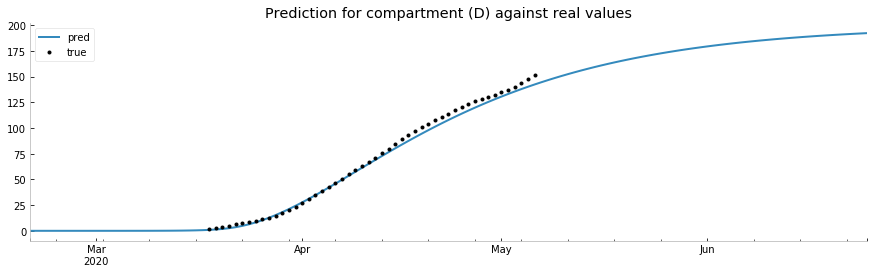

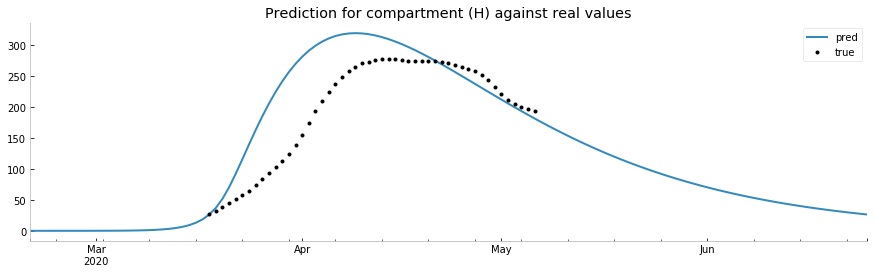

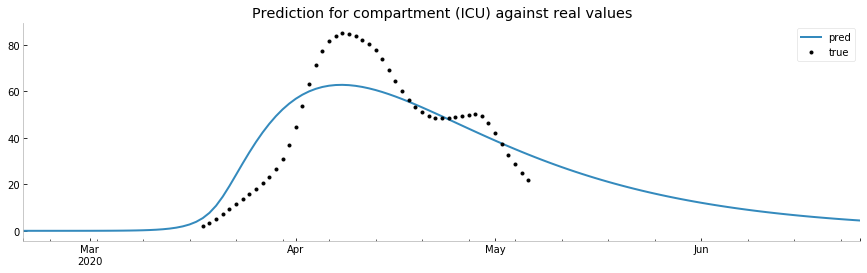

DEP=07====================================================================================================
Initialized with N=326875 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.4681622093382813
... Found best solution {'beta_low': 0.29175721888379297, 'beta_high': 1.443977953141206, 'offset': -23.71589492371396, 'proba_icu': 0.16678104807213998, 'proba_death_hospital': 0.19939731258502946, 'recovery_duration_hospital': 5.251890402969629, 'recovery_duration_icu': 7.429526635915763, 'death_duration_icu': 10.01814158580052, 'death_duration_hospital': 78.06708216209216} for value 0.4681622093382813
... Parameters saved in yaml file params/calibration_DEP-07.yaml
                    D           H        ICU
2020-03-18   0.000000   10.505904   1.323535
2020-03-19   1.000000   12.279410   1.807674
2020-03-20   1.000000   14.628613   2.312264
2020-03-21   1.000000   17.818705   2.764168
2020-03-22   1.403207   22.348693   3.190572
2020-03-23   2.056512   28.291375   3.693045
2020-03-24   2.939961   35.372781   4.388851
2020-03-25   4.096141   42.932820   5.303437
2020-03-26   5.564139   50.078117  

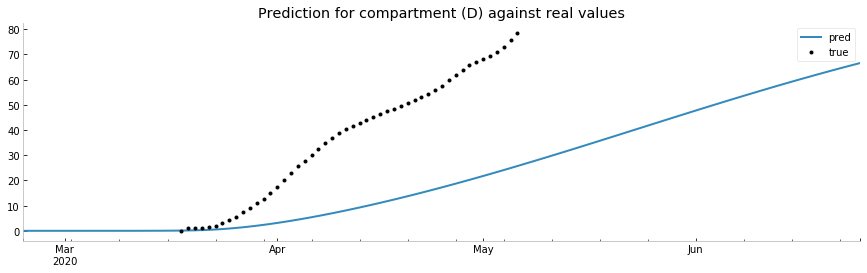

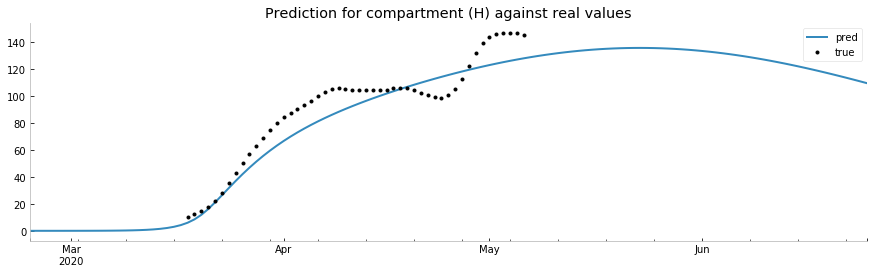

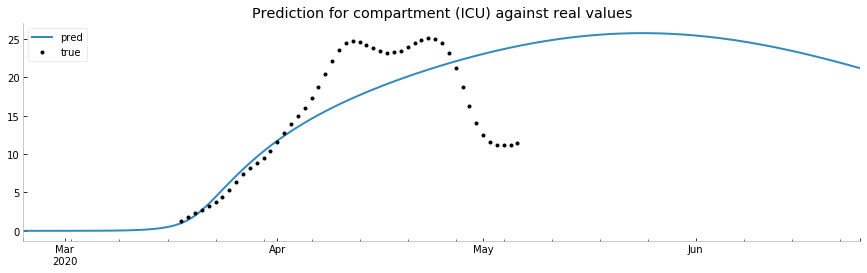

DEP=08====================================================================================================
Initialized with N=265531 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.2442748787213975
... Found best solution {'beta_low': 0.17783147707890046, 'beta_high': 1.534170330253941, 'offset': -21.518173262882097, 'proba_icu': 0.1924837274308223, 'proba_death_hospital': 0.19998050372959547, 'recovery_duration_hospital': 18.459749480564295, 'recovery_duration_icu': 18.11093443853755, 'death_duration_icu': 26.276785439188476, 'death_duration_hospital': 12.398093426816297} for value 0.2442748787213975
... Parameters saved in yaml file params/calibration_DEP-08.yaml
                    D          H        ICU
2020-03-18   1.000000   0.000000   0.000000
2020-03-19   1.000000   1.000000   1.000000
2020-03-20   1.000000   1.078689   1.000000
2020-03-21   1.000000   2.091254   1.000000
2020-03-22   0.000000   3.315328   1.525586
2020-03-23   0.000000   4.651044   2.232781
2020-03-24   0.000000   6.102551   3.091731
2020-03-25   0.000000   8.071532   4.178078
2020-03-26   0.000000  11.134320   5.6008

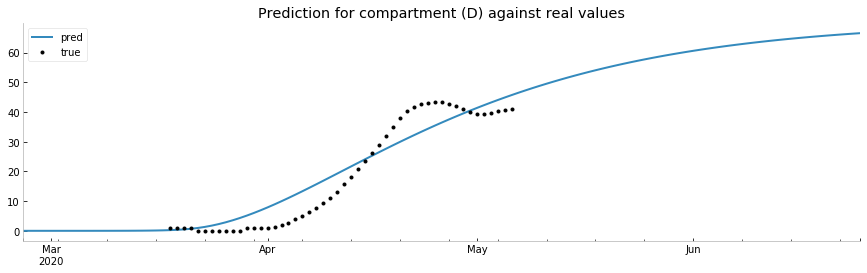

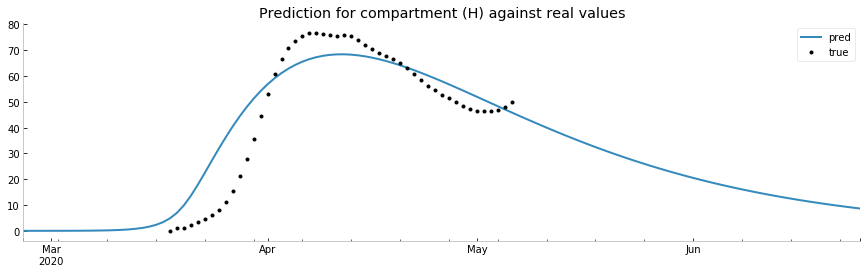

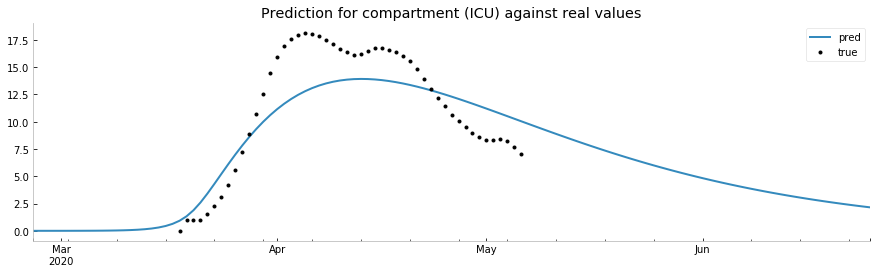

DEP=09====================================================================================================
Initialized with N=152398 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.27770347887177765
... Found best solution {'beta_low': 0.06439845391101919, 'beta_high': 1.0700620693107852, 'offset': -25.643997314214204, 'proba_icu': 0.20941328360779707, 'proba_death_hospital': 0.1699545167671514, 'recovery_duration_hospital': 19.151671984683407, 'recovery_duration_icu': 16.029833298411308, 'death_duration_icu': 78.91272335824458, 'death_duration_hospital': 54.580311384331} for value 0.27770347887177765
... Parameters saved in yaml file params/calibration_DEP-09.yaml
                   D          H       ICU
2020-03-18  1.000000   1.000000  1.000000
2020-03-19  1.000000   1.217785  1.000000
2020-03-20  1.000000   1.565815  1.117642
2020-03-21  1.000000   1.954129  1.328904
2020-03-22  0.000000   2.433626  1.637583
2020-03-23  0.000000   3.097206  2.015369
2020-03-24  0.000000   3.995109  2.263258
2020-03-25  0.000000   5.168318  2.279974
2020-03-26  0.000000   6.381728  2.103661
2020-03-27  0.000

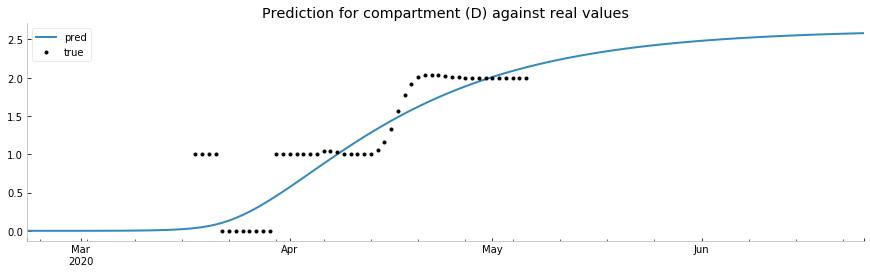

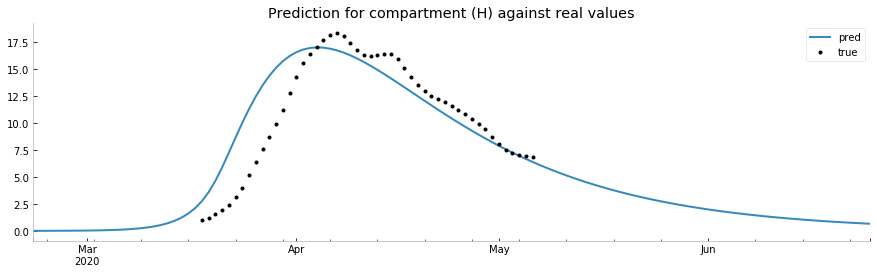

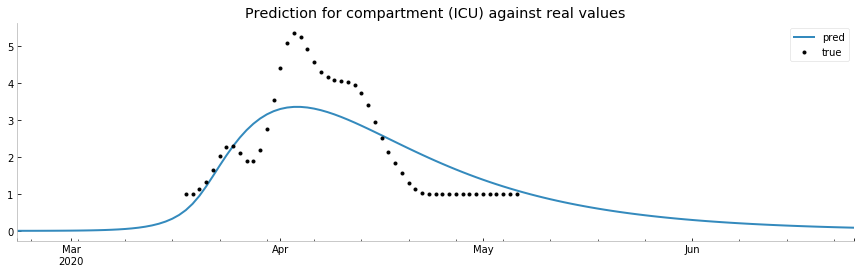

DEP=10====================================================================================================
Initialized with N=309907 and lockdown -1 after 2020-03-18 00:00:00


... Found best solution {'beta_low': 0.2191053568190674, 'beta_high': 1.415380266050769, 'offset': -25.85614450125673, 'proba_icu': 0.16512940326544173, 'proba_death_hospital': 0.1625838222944714, 'recovery_duration_hospital': 17.83301081952062, 'recovery_duration_icu': 7.371498165860213, 'death_duration_icu': 55.621034804970904, 'death_duration_hospital': 11.482967718411977} for value 0.21378551849798802
... Parameters saved in yaml file params/calibration_DEP-10.yaml
                     D           H        ICU
2020-03-18    0.000000    4.774779   1.000000
2020-03-19    0.000000    7.049998   1.000000
2020-03-20    1.000000   10.290540   1.480144
2020-03-21    1.000000   14.676140   2.324955
2020-03-22    1.000000   20.682656   3.340252
2020-03-23    1.317673   28.179034   4.524752
2020-03-24    2.337194   36.399020   6.025229
2020-03-25    3.651618   44.798525   7.997140
2020-03-26    4.928053   52.662443  10.080535
2020-03-27    5.964601   59.078700  11.743492
2020-03-28    6.8108

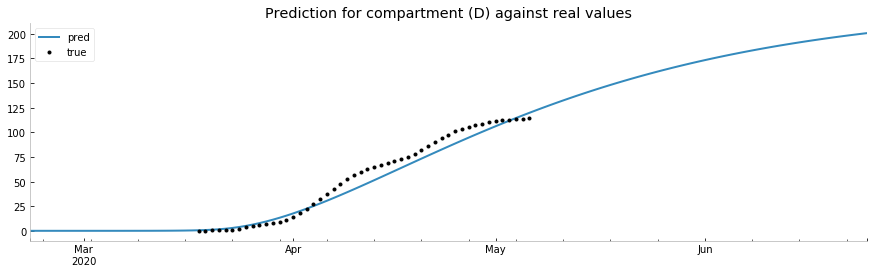

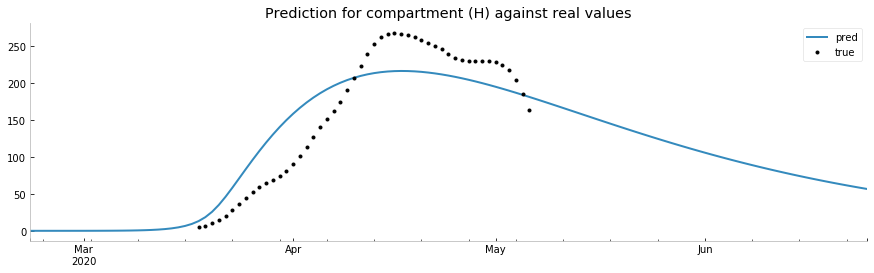

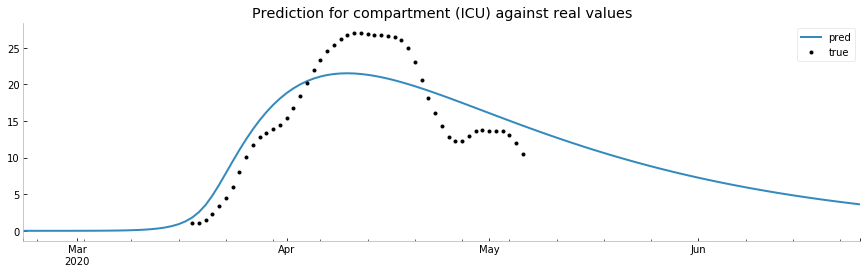

DEP=11====================================================================================================
Initialized with N=372705 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.2554663506099274
... Found best solution {'beta_low': 0.10292316812840104, 'beta_high': 1.8149668275422461, 'offset': -20.849363680100527, 'proba_icu': 0.14841589282584713, 'proba_death_hospital': 0.15617631107065436, 'recovery_duration_hospital': 10.027307602736453, 'recovery_duration_icu': 12.603351263714178, 'death_duration_icu': 25.972162039940567, 'death_duration_hospital': 10.10159538199406} for value 0.2554663506099274
... Parameters saved in yaml file params/calibration_DEP-11.yaml
                    D          H        ICU
2020-03-18   3.880882  11.013643   8.316307
2020-03-19   5.277896  15.406436   9.072423
2020-03-20   6.821676  20.393636   9.627706
2020-03-21   8.304449  25.038439   9.983568
2020-03-22   9.653021  29.012841  10.378037
2020-03-23  10.971313  32.433565  10.910058
2020-03-24  12.329002  35.327830  11.439845
2020-03-25  13.644024  38.492828  12.138226
2020-03-26  14.747573  42.597155  13.13

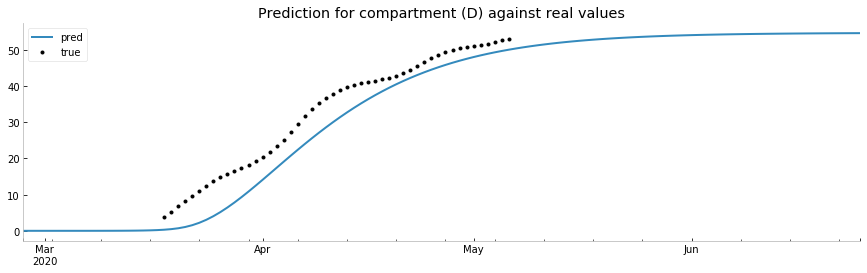

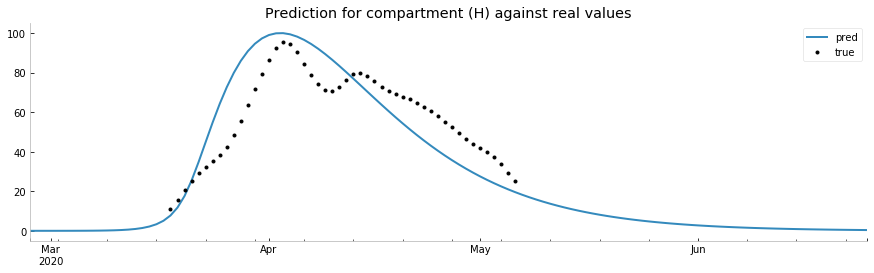

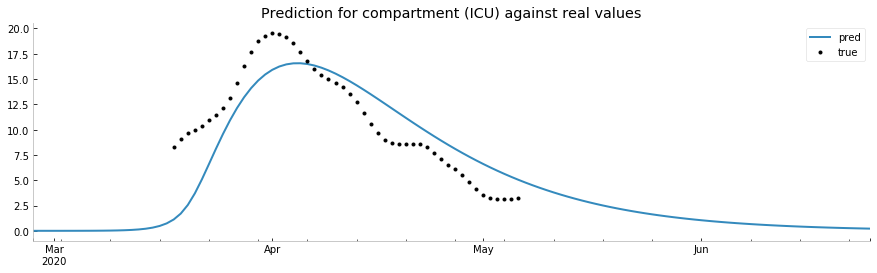

DEP=12====================================================================================================
Initialized with N=278360 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.22509809826895588
... Found best solution {'beta_low': 0.1615883498724581, 'beta_high': 1.7371745549338793, 'offset': -19.85849341421502, 'proba_icu': 0.17811000916860917, 'proba_death_hospital': 0.19195751812173373, 'recovery_duration_hospital': 9.417389655390943, 'recovery_duration_icu': 5.870249969670469, 'death_duration_icu': 29.05165448900718, 'death_duration_hospital': 16.07887560440172} for value 0.22509809826895588
... Parameters saved in yaml file params/calibration_DEP-12.yaml
                    D          H        ICU
2020-03-18   1.000000   7.535879   1.899848
2020-03-19   1.000000   8.863741   1.913129
2020-03-20   1.000000  10.280537   1.942412
2020-03-21   1.000000  11.663699   2.018616
2020-03-22   1.000280  13.159249   2.187285
2020-03-23   1.165336  14.861135   2.506394
2020-03-24   1.463682  16.874018   3.029374
2020-03-25   2.008864  19.165300   3.729591
2020-03-26   2.896045  22.077655   4.53837

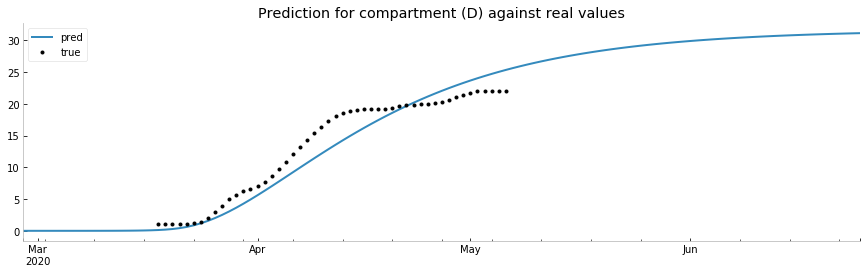

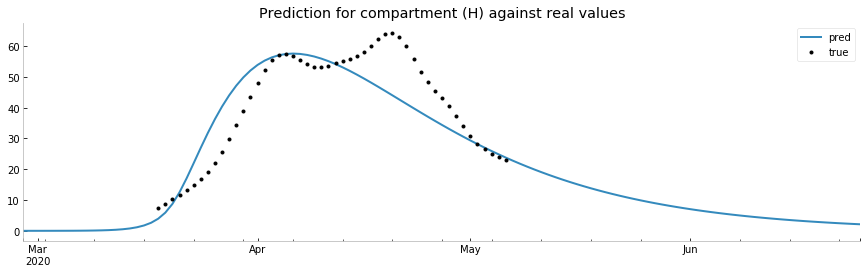

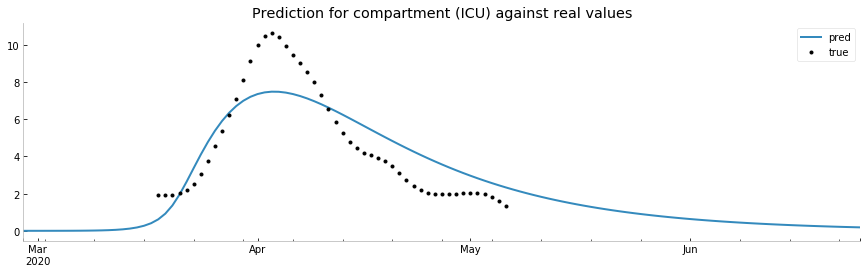

DEP=13====================================================================================================
Initialized with N=2034469 and lockdown -1 after 2020-03-18 00:00:00


... Found best solution {'beta_low': 0.19895666392872327, 'beta_high': 1.9679111452623796, 'offset': -23.93531275693505, 'proba_icu': 0.18815556865531982, 'proba_death_hospital': 0.1156511647583145, 'recovery_duration_hospital': 14.203892811578314, 'recovery_duration_icu': 12.815802046378062, 'death_duration_icu': 65.86981874590056, 'death_duration_hospital': 11.786416713570018} for value 0.10615829234111708
... Parameters saved in yaml file params/calibration_DEP-13.yaml
                     D            H         ICU
2020-03-18    3.711546   102.427310   12.555589
2020-03-19    3.743735   130.241714   17.978957
2020-03-20    3.821769   164.374501   25.058915
2020-03-21    4.037400   203.921743   33.972925
2020-03-22    4.538953   248.530904   44.986036
2020-03-23    5.556309   297.166021   58.115947
2020-03-24    7.405776   347.772751   72.069139
2020-03-25   10.246790   400.311907   85.710839
2020-03-26   14.011343   459.772576   99.678629
2020-03-27   18.553511   529.180498  114.74

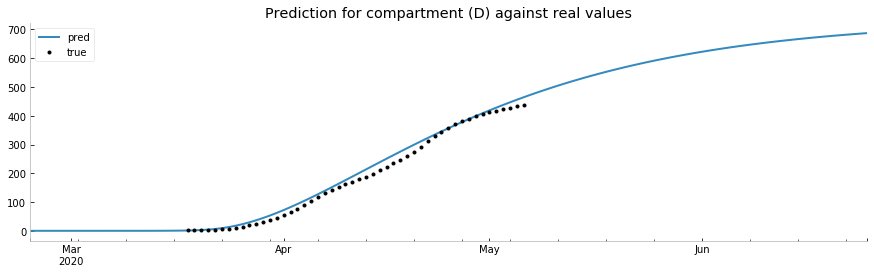

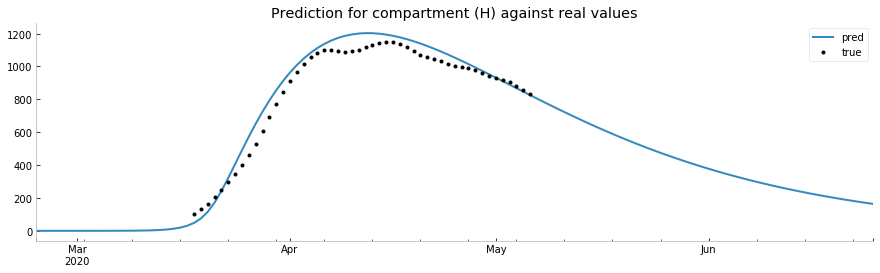

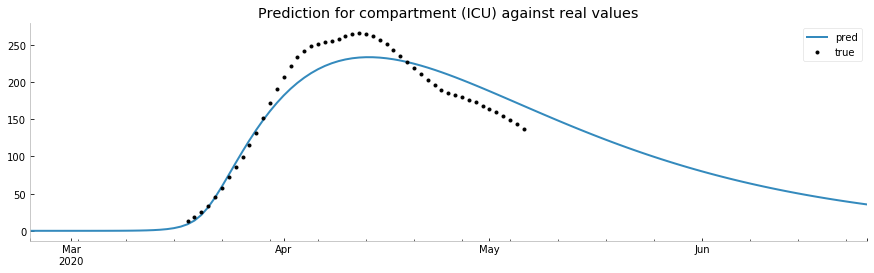

DEP=14====================================================================================================
Initialized with N=691453 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.2244101469008833
... Found best solution {'beta_low': 0.21025863661448693, 'beta_high': 1.8304491194978714, 'offset': -21.21751995337822, 'proba_icu': 0.21988464889595724, 'proba_death_hospital': 0.1865826624724152, 'recovery_duration_hospital': 8.723376569938756, 'recovery_duration_icu': 9.577336030113385, 'death_duration_icu': 80.82728911610681, 'death_duration_hospital': 18.22393104966305} for value 0.2244101469008833
... Parameters saved in yaml file params/calibration_DEP-14.yaml
                    D           H        ICU
2020-03-18   1.000000    3.001905   1.000000
2020-03-19   1.000000    3.990407   1.095271
2020-03-20   1.000000    5.448781   1.710511
2020-03-21   1.000000    7.951542   2.688904
2020-03-22   1.000000   12.283769   4.141106
2020-03-23   1.000000   19.164378   6.234896
2020-03-24   1.041994   28.475607   9.092396
2020-03-25   1.144356   39.927394  12.627578
2020-03-26   1.349843   52.397780  

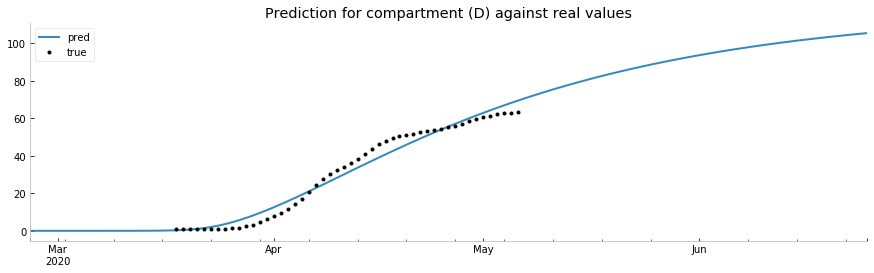

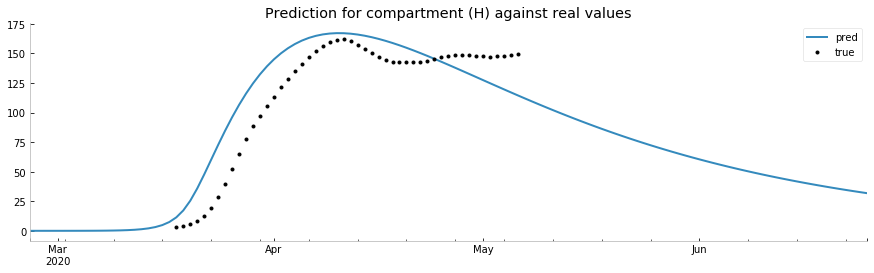

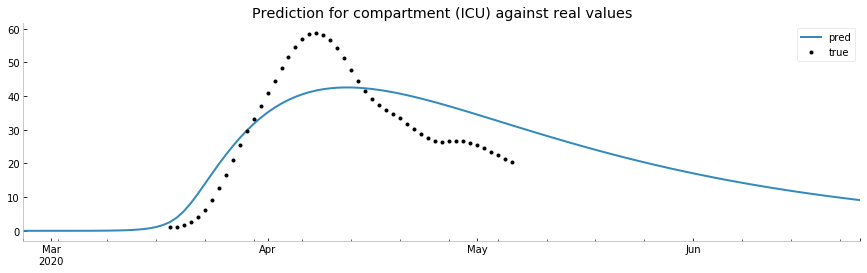

DEP=15====================================================================================================
Initialized with N=142811 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.33107086786181417
... Found best solution {'beta_low': 0.22048393367862365, 'beta_high': 1.6450340714446816, 'offset': -18.190486249871416, 'proba_icu': 0.15670088375295413, 'proba_death_hospital': 0.09883239376202828, 'recovery_duration_hospital': 9.42328358347777, 'recovery_duration_icu': 12.570549489507659, 'death_duration_icu': 39.52761986691654, 'death_duration_hospital': 40.08316492864968} for value 0.33107086786181417
... Parameters saved in yaml file params/calibration_DEP-15.yaml
                   D          H       ICU
2020-03-18  0.000000   2.296665  1.000000
2020-03-19  0.000000   2.975029  1.000000
2020-03-20  0.000000   3.721209  1.034020
2020-03-21  1.000000   4.446231  1.211201
2020-03-22  1.000000   5.072090  1.516593
2020-03-23  1.000000   5.612683  1.996597
2020-03-24  1.000000   6.095495  2.596072
2020-03-25  1.000000   6.450152  3.190306
2020-03-26  1.000000   6.749508  3.646330
2020-03-27  1.00

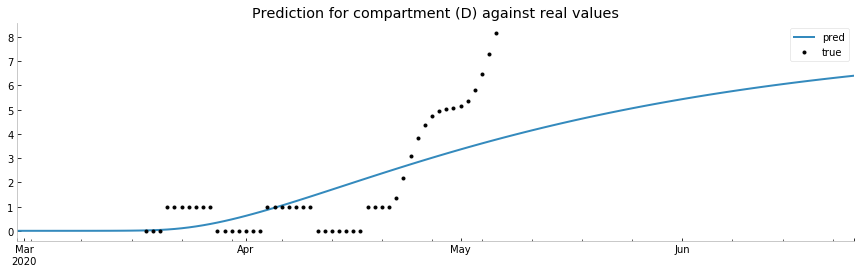

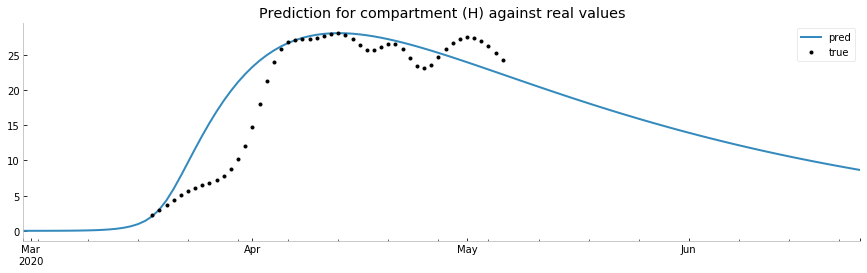

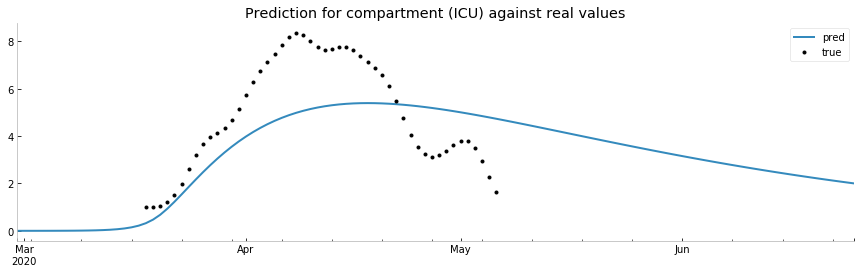

DEP=16====================================================================================================
Initialized with N=348180 and lockdown -1 after 2020-03-18 00:00:00


... Found best solution {'beta_low': 0.010167805257216363, 'beta_high': 1.1837710751306536, 'offset': -25.700967460552302, 'proba_icu': 0.21814018374358313, 'proba_death_hospital': 0.15020878791125197, 'recovery_duration_hospital': 16.023293724284898, 'recovery_duration_icu': 12.963158296767045, 'death_duration_icu': 56.10447003843608, 'death_duration_hospital': 10.110522249484468} for value 0.2335644583573258
... Parameters saved in yaml file params/calibration_DEP-16.yaml
                    D          H       ICU
2020-03-18   0.000000   1.000000  0.000000
2020-03-19   0.000000   1.095260  1.000000
2020-03-20   1.000000   1.785959  1.000000
2020-03-21   1.000000   2.926792  1.115268
2020-03-22   1.000000   4.707463  1.928499
2020-03-23   1.287265   7.346207  2.743930
2020-03-24   2.065137  11.076704  3.360494
2020-03-25   3.023389  15.533720  3.780727
2020-03-26   3.980714  19.968825  4.211194
2020-03-27   4.796923  23.662592  4.797098
2020-03-28   5.327433  25.727424  5.475585
2020-

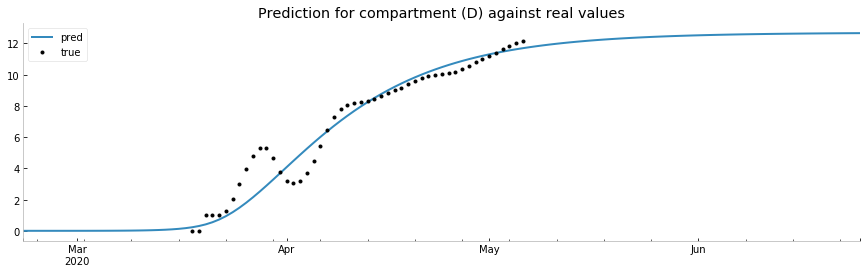

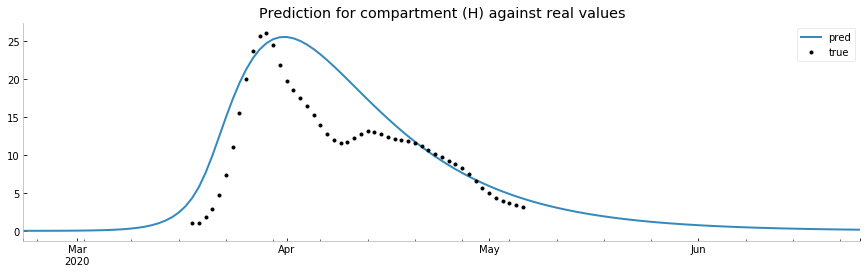

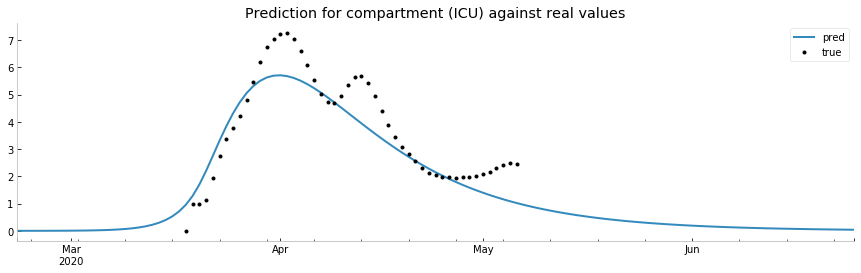

DEP=17====================================================================================================
Initialized with N=647080 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.2307033045528845
... Found best solution {'beta_low': 0.18567803578376377, 'beta_high': 1.6113180719755265, 'offset': -21.95707819006242, 'proba_icu': 0.1579444205653282, 'proba_death_hospital': 0.19277733114232115, 'recovery_duration_hospital': 9.733077089783762, 'recovery_duration_icu': 18.872428867595875, 'death_duration_icu': 29.680178412854822, 'death_duration_hospital': 16.213890038384008} for value 0.2307033045528845
... Parameters saved in yaml file params/calibration_DEP-17.yaml
                    D          H        ICU
2020-03-18   1.000000   5.238518   1.854564
2020-03-19   0.000000   6.715677   2.322362
2020-03-20   0.000000   8.483263   2.897688
2020-03-21   0.000000  10.578132   3.570684
2020-03-22   0.000000  13.154956   4.334955
2020-03-23   0.000000  16.569009   5.261167
2020-03-24   0.000000  21.142140   6.386671
2020-03-25   1.000000  26.328217   7.915706
2020-03-26   1.000000  31.884502  10.1092

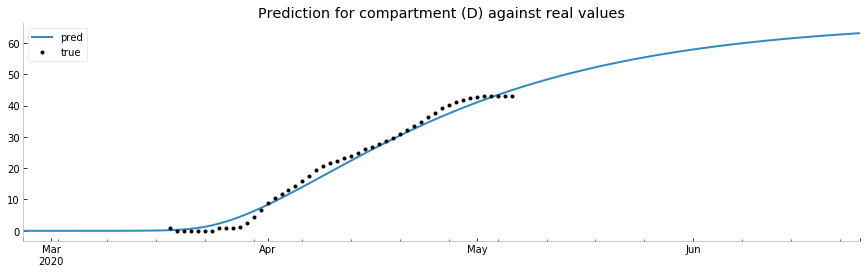

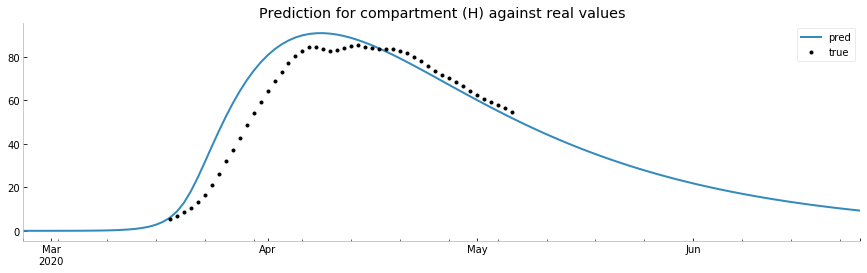

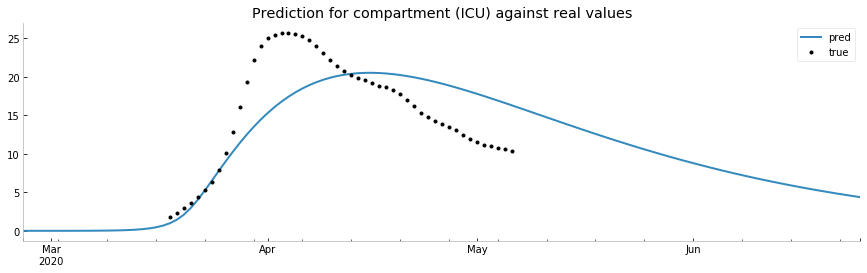

DEP=18====================================================================================================
Initialized with N=296404 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.34905369570470335
... Found best solution {'beta_low': 0.21959907413803986, 'beta_high': 1.7804370477366918, 'offset': -19.069989084788894, 'proba_icu': 0.14658167341034709, 'proba_death_hospital': 0.1894663978674562, 'recovery_duration_hospital': 15.721973361241076, 'recovery_duration_icu': 8.109977669741369, 'death_duration_icu': 27.082536039378805, 'death_duration_hospital': 10.02522244874674} for value 0.34905369570470335
... Parameters saved in yaml file params/calibration_DEP-18.yaml
                    D          H        ICU
2020-03-18   0.000000   0.000000   0.000000
2020-03-19   0.000000   0.000000   0.000000
2020-03-20   0.000000   0.000000   0.000000
2020-03-21   0.000000   1.000000   1.000000
2020-03-22   0.000000   1.000000   1.000000
2020-03-23   1.000000   1.000000   1.000000
2020-03-24   1.000000   1.979614   1.555476
2020-03-25   1.000000   4.086066   2.803258
2020-03-26   1.000000   7.238641   4.26

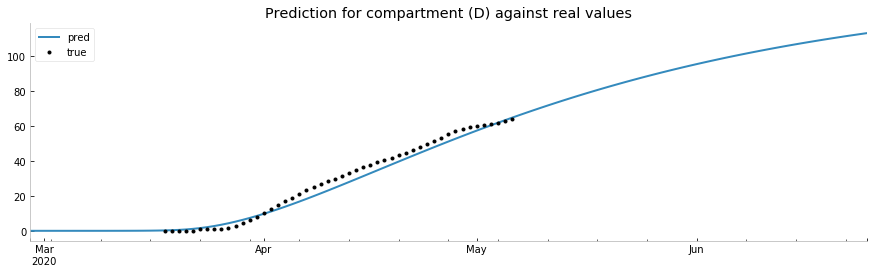

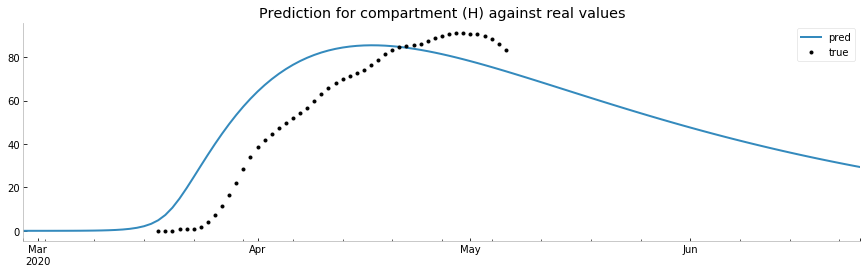

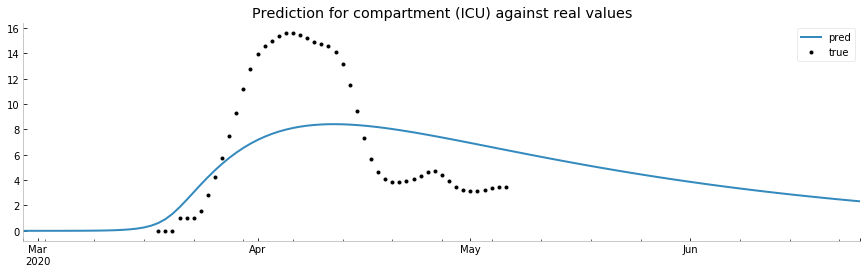

DEP=19====================================================================================================
Initialized with N=240336 and lockdown -1 after 2020-03-18 00:00:00


... Early stopping - best value has not changed since 200 trials at 0.1512637751757215
... Found best solution {'beta_low': 0.2308627298803796, 'beta_high': 1.4162653859684722, 'offset': -21.95299185783257, 'proba_icu': 0.2079295600642181, 'proba_death_hospital': 0.13948383076090112, 'recovery_duration_hospital': 17.82127050978482, 'recovery_duration_icu': 11.06873664144859, 'death_duration_icu': 18.769366054580736, 'death_duration_hospital': 11.69518625087869} for value 0.1512637751757215
... Parameters saved in yaml file params/calibration_DEP-19.yaml
                    D          H        ICU
2020-03-18   0.000000   1.000000   0.000000
2020-03-19   0.000000   1.000000   0.000000
2020-03-20   1.000000   1.136147   1.000000
2020-03-21   1.000000   2.075652   1.000000
2020-03-22   1.000000   3.637460   1.000000
2020-03-23   1.551059   5.994648   1.142929
2020-03-24   2.192526   9.203064   2.123500
2020-03-25   2.688296  12.917582   3.377826
2020-03-26   2.972533  16.843863   4.703899


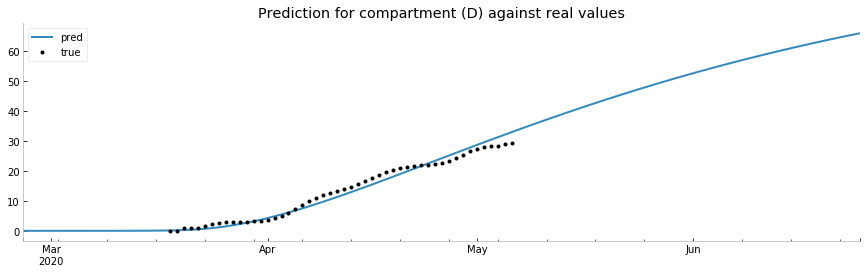

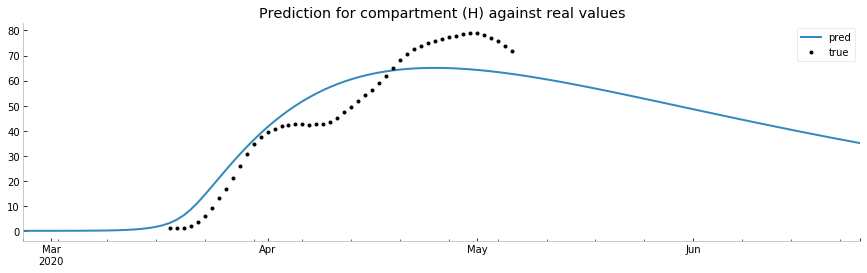

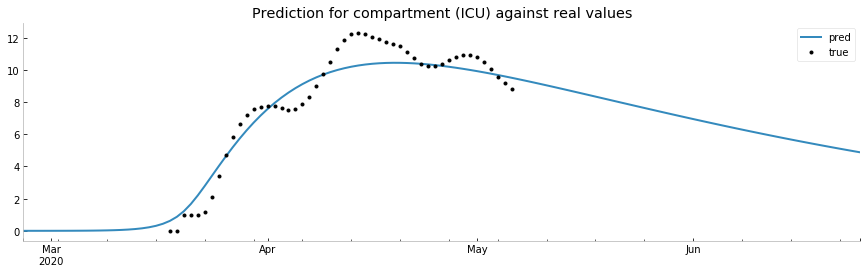

DEP=21====================================================================================================
Initialized with N=532886 and lockdown -1 after 2020-03-18 00:00:00


In [ ]:
for dep in deps:
    print("DEP="+dep+"="*100)
    try:
        optimize_dep(dep,1000,200)
    except Exception as e:
        print("... Skipped dep {dep} because of {e}")